In [88]:
#### Dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from Functions.Preprocess import scale_shift_feats, tracks_to_df
from Functions.Models import cnn, lstm, lstm_big, train, lstm_mask
from Functions.Evaluate import compareAB, compareAB1
import tensorflow as tf
#### Parameters
N = 100000 # Total number of events in data
max_ev = 6*N # Maximum number of events to load (before PT and 2jet cuts)
r = 0.5 # Signal proportion from total events
mult_thresh = 20 # Jet1 multiplicity threshold for initial cut
model_name = "lstm_mask" # Model for classification
bkg_path = ["Data/from_cluster/bb{}.root.GetTracks.txt".format(i) for i in range(1,3)]
sig_path = ["Data/from_cluster/dark{}.root.GetTracks.txt".format(i) for i in range(1,3)]
n_constits = 30
sort = "D0"
feats = ["track_D0", "track_DZ"] + ["track_PT", "track_Eta", "track_Phi"] 
jet_feats = ["jet_PT", "jet_Eta", "jet_Phi"]
PT_cut = (100, 200)
val_frac = 0.2
analysis_dir = "Semi-supervised"

Number of Background events with two jets is  54615  out of  77334
Number of Signal events with two jets is  42186  out of  70148
----------
N =  92187
#B =  50001
#S =  42186
----------
#B' =  62033  with S/B of  0.30807835860236593
#S' =  30154  with S/B of  10.6966640806827
Background efficiencey of multiplicity cut is =  0.05155896882062359
Signal efficiencey of multiplicity cut is =  0.6536765751671171
----------
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_16 (Masking)         (None, 30, 5)             0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 50)                11200     
_________________________________________________________________
dense_32 (Dense)             (None, 16)                816       
_________________________________________________________________
dense_33 (Dense)           

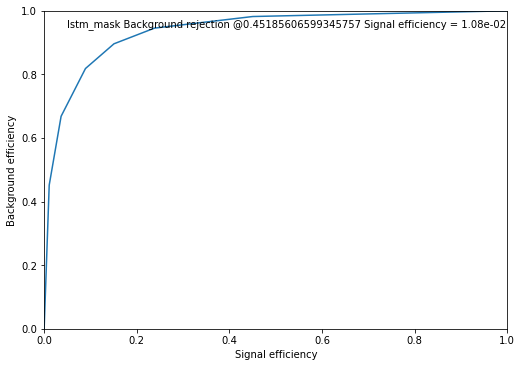

<AxesSubplot:>

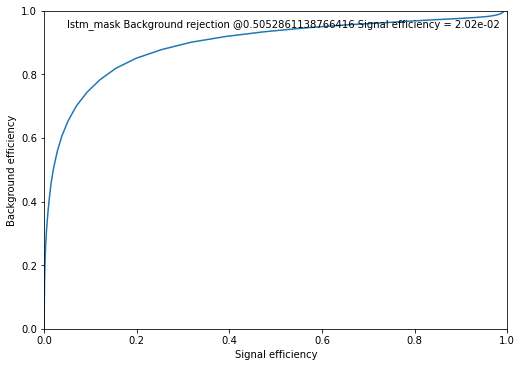

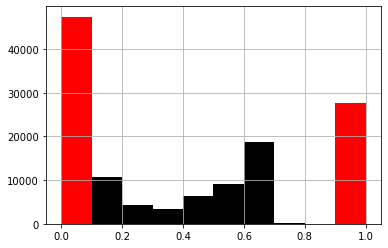

In [89]:
#### Preprocessing
# Load signal and background
bkg_j = tracks_to_df(bkg_path, label=0, max_ev=max_ev, n_constits=n_constits, trunc=False, PT_cut=PT_cut, sort=sort) 
sig_j = tracks_to_df(sig_path, label=1, max_ev=max_ev, n_constits=n_constits, trunc=False, PT_cut=PT_cut, sort=sort)
# Clean single jet events
bkg_evs_2jet = bkg_j.Event.value_counts()[bkg_j.Event.value_counts()>1].index  # Events with two jets
sig_evs_2jet = sig_j.Event.value_counts()[sig_j.Event.value_counts()>1].index
print("Number of Background events with two jets is ", len(bkg_evs_2jet), " out of ", len(bkg_j.Event.value_counts())) # Output number of events with two jets
print("Number of Signal events with two jets is ",len(sig_evs_2jet), " out of ", len(sig_j.Event.value_counts()))
print("----------")
bkg_j = bkg_j.loc[bkg_j.Event.map(lambda x: x in bkg_evs_2jet)].reset_index() # Clean single jet events
sig_j = sig_j.loc[sig_j.Event.map(lambda x: x in sig_evs_2jet)].reset_index()
# Group by jet
bkg_j1 = bkg_j[bkg_j.Jet==1][['Event'] + feats + jet_feats + ['label']] # Seperate
bkg_j2 = bkg_j[bkg_j.Jet==2][['Event'] + feats + jet_feats]
bkg_j1 = bkg_j1.rename(columns={feat : feat+"1" for feat in (feats+jet_feats)}) # Rename
bkg_j2 = bkg_j2.rename(columns={feat : feat+"2" for feat in (feats+jet_feats)})
bkg_ev = pd.merge(bkg_j2, bkg_j1, on='Event') # Merge
sig_j1 = sig_j[sig_j.Jet==1][['Event'] + feats + jet_feats + ['label']] # Seperate
sig_j2 = sig_j[sig_j.Jet==2][['Event'] + feats + jet_feats]
sig_j1 = sig_j1.rename(columns={feat : feat+"1" for feat in (feats+jet_feats)}) # Rename
sig_j2 = sig_j2.rename(columns={feat : feat+"2" for feat in (feats+jet_feats)})
sig_ev = pd.merge(sig_j2, sig_j1, on='Event') # Merge
# Create data sample with specified proportions
data = pd.concat([sig_ev.loc[:int(N*r)], bkg_ev.loc[:int(N*(1-r))]]).sample(frac=1).reset_index()
print("N = ", len(data))
print("#B = ", len(data[(data.label==0)]))
print("#S = ", len(data[(data.label==1)]))
print("----------")
#### Seperate events into two groups S' (mult_thres=1) B'(mult_thresh=0) by cutting on jet1 multiplicity
data["j1_mult"] = data.track_PT1.map(lambda x : len(x))
data["j1_mult_cut"] = (data.j1_mult>mult_thresh).astype(np.int)
# Output cut efficiencies
B_tag_SNR = len(data[(data.j1_mult_cut==0) & (data.label==1)]) / len(data[(data.j1_mult_cut==0) & (data.label==0)])
S_tag_SNR = len(data[(data.j1_mult_cut==1) & (data.label==1)]) / len(data[(data.j1_mult_cut==1) & (data.label==0)])
print("#B' = ", len(data[(data.j1_mult_cut==0)]), " with S/B of ", B_tag_SNR)
print("#S' = ", len(data[(data.j1_mult_cut==1)]), " with S/B of ", S_tag_SNR)
print("Background efficiencey of multiplicity cut is = ", len(data[(data.label==0) & (data.j1_mult_cut==1)])/len(data[data.label==0]))
print("Signal efficiencey of multiplicity cut is = ", len(data[(data.label==1) & (data.j1_mult_cut==1)])/len(data[data.label==1]))
print("----------")
#### Train classifier to distinguish between S' anb B' using jet2 features
# Preprocessing for NN
#data.track_PT2 = data.track_PT2 / data.track_PT2.map(np.max) # Scale and shift
#data.track_Eta2 = (data.track_Eta2 - data.jet_Eta2) * 10
#data.track_Phi2 = (data.track_Phi2 - data.jet_Phi2) * 10
#data.track_DZ2 = data.track_DZ2 / np.cosh(data.jet_Eta2)
j2_feats_for_nn = np.concatenate(np.array(data[[feat+"2" for feat in feats]]
                                          .applymap(lambda x: np.append(x[:n_constits], [-10.0] * (n_constits - len(x)))))
                                          .flatten()).reshape((len(data), n_constits, len(feats)))
train_ind = np.arange(0, int(len(data) * (1 - val_frac)))
val_ind = np.arange(int(len(data) * (1 - val_frac)), len(data))
X_train = j2_feats_for_nn[train_ind]
X_val = j2_feats_for_nn[val_ind]
y_train = data.iloc[train_ind]["j1_mult_cut"]
y_val = data.loc[val_ind]["j1_mult_cut"]
# Train
model = lstm_mask(n_constits, feats)
train(model, X_train, y_train, X_val, y_val, model_name, epochs=100)
#### Seperate data into two groups S_pred B_pred by cutting on jet2 classification output
model = tf.keras.models.load_model("Models/"+model_name)
data["nn_out"] = model.predict(j2_feats_for_nn).flatten()
# Second classifier ROC curve
plt.figure()
bkg_eff = []
sig_eff = []
closest_half_sig_eff = 0
bkg_eff_closest_half_sig_eff = 0
for nn_thresh in np.arange(0, 1, 0.1):
    bkg_eff_temp = len(data[(data.label==0) & (data.nn_out>nn_thresh)])/len(data[data.label==0])
    sig_eff_temp = len(data[(data.label==1) & (data.nn_out>nn_thresh)])/len(data[data.label==1])
    bkg_eff.append(bkg_eff_temp)
    sig_eff.append(sig_eff_temp)
    if abs(sig_eff_temp - 0.5) < abs(closest_half_sig_eff - 0.5):
        closest_half_sig_eff = sig_eff_temp
        bkg_eff_closest_half_sig_eff = bkg_eff_temp
plt.plot(bkg_eff, sig_eff)
plt.xlim([0,1])
plt.ylim([0,1])
plt.annotate(model_name + ' Background rejection @{} Signal efficiency = {:.2e}'.format(closest_half_sig_eff, bkg_eff_closest_half_sig_eff), xy=(0.05, 0.95), xycoords='axes fraction')
plt.xlabel("Signal efficiency")
plt.ylabel("Background efficiency")
plt.gcf().set_size_inches(8.3, 5.85)
plt.savefig(analysis_dir + "ROC_" + model_name + ".pdf", format="pdf")
plt.savefig(analysis_dir + "ROC_" + model_name + ".svg", format="svg")
plt.show()
# Multiplicity cut ROC curve
bkg_eff = []
sig_eff = []
closest_half_sig_eff = 0
bkg_eff_closest_half_sig_eff = 0
for mult_threshold in np.arange(1, 50):
    bkg_eff_temp = len(data[(data.label==0) & (data.j1_mult>mult_threshold)])/len(data[data.label==0])
    sig_eff_temp = len(data[(data.label==1) & (data.j1_mult>mult_threshold)])/len(data[data.label==1])
    bkg_eff.append(bkg_eff_temp)
    sig_eff.append(sig_eff_temp)
    if abs(sig_eff_temp - 0.5) < abs(closest_half_sig_eff - 0.5):
        closest_half_sig_eff = sig_eff_temp
        bkg_eff_closest_half_sig_eff = bkg_eff_temp
plt.plot(bkg_eff, sig_eff)
plt.xlim([0,1])
plt.ylim([0,1])
plt.annotate(model_name + ' Background rejection @{} Signal efficiency = {:.2e}'.format(closest_half_sig_eff, bkg_eff_closest_half_sig_eff), xy=(0.05, 0.95), xycoords='axes fraction')
plt.xlabel("Signal efficiency")
plt.ylabel("Background efficiency")
plt.gcf().set_size_inches(8.3, 5.85)
plt.savefig(analysis_dir + "ROC_" + model_name + ".pdf", format="pdf")
plt.savefig(analysis_dir + "ROC_" + model_name + ".svg", format="svg")
# NN output vs multiplicity cut histograms
plt.figure()
data[(data.label==1)].nn_out.hist(range=[0, 1], color='black')
data[(data.label==0)].nn_out.hist(range=[0, 1], color='black')
data[(data.label==1)].j1_mult_cut.hist(range=[0, 1], color='red')
data[(data.label==0)].j1_mult_cut.hist(range=[0, 1], color='red')